In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
from tensorflow import keras

In [3]:
tf.__version__

'2.2.0'

In [4]:
keras.__version__

'2.3.0-tf'

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [6]:
X_train_full.shape

(60000, 28, 28)

In [24]:
y_train_full.shape

(60000,)

In [28]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [29]:
class_names[y_train_full[0]]

'Ankle boot'

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [7]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

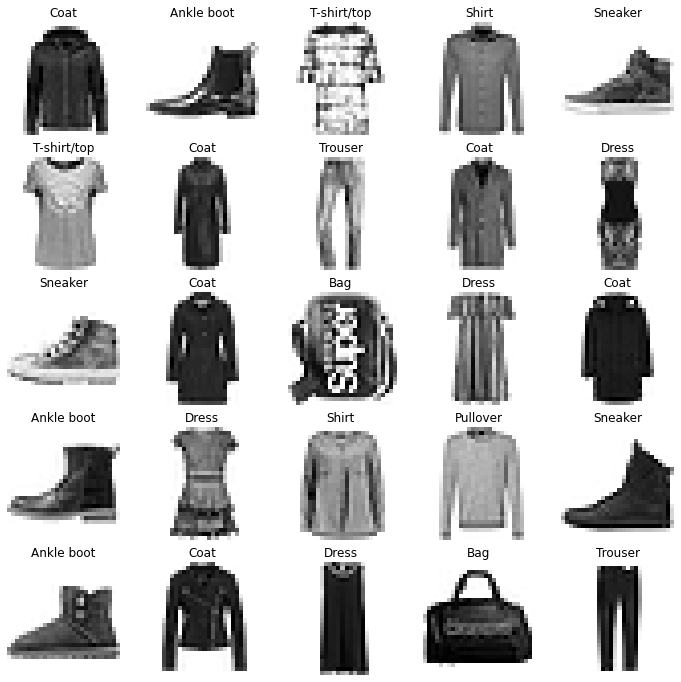

In [30]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(12, 12))
for i in range(25):
    ax[i%5, int(i/5)].imshow(X_train[i], cmap="binary")
    ax[i%5, int(i/5)].axis('off')
    ax[i%5, int(i/5)].set_title(class_names[y_train[i]])
plt.show()

Saving figure fashion_mnist_plot


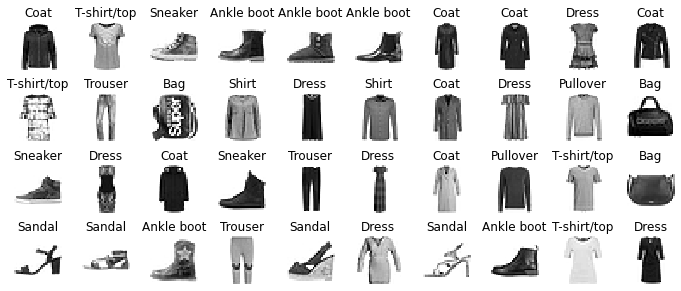

In [31]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [32]:
X_valid.shape

(5000, 28, 28)

In [33]:
X_test.shape

(10000, 28, 28)

In [34]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dense(20, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [35]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [36]:
model.layers

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 30)                23550     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
Total params: 24,380
Trainable params: 24,380
Non-trainable params: 0
_________________________________________________________________


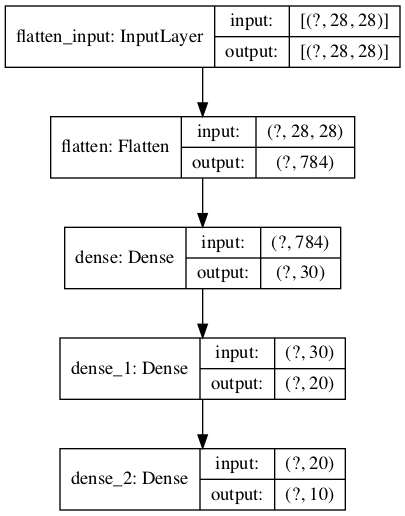

In [38]:
keras.utils.plot_model(model, "my_fashion_mnist_model_v01.png", show_shapes=True)

In [39]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [40]:
model.get_layer(hidden1.name) is hidden1

True

In [41]:
weights, biases = hidden1.get_weights()

In [43]:
weights[0]

array([-0.05950938, -0.063171  ,  0.03075215,  0.08271646, -0.0335467 ,
        0.02354898, -0.04750289, -0.08488682, -0.08064576, -0.01556027,
       -0.05510559, -0.07695776, -0.08476882,  0.04787701, -0.01081106,
        0.01721855,  0.07357711, -0.04764332,  0.04686479, -0.00304416,
       -0.00814456, -0.04837448,  0.04738218,  0.03148317,  0.07368542,
        0.04583663,  0.04092673, -0.03827639, -0.06710221, -0.00323159],
      dtype=float32)

In [44]:
weights.shape

(784, 30)

In [45]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [46]:
biases.shape

(30,)

In [47]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [49]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.8970 - accuracy: 0.7012 - val_loss: 0.5858 - val_accuracy: 0.8000
Epoch 2/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5450 - accuracy: 0.8111 - val_loss: 0.4886 - val_accuracy: 0.8318
Epoch 3/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4879 - accuracy: 0.8292 - val_loss: 0.5714 - val_accuracy: 0.7926
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4570 - accuracy: 0.8396 - val_loss: 0.4358 - val_accuracy: 0.8494
Epoch 5/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4374 - accuracy: 0.8471 - val_loss: 0.4204 - val_accuracy: 0.8530
Epoch 6/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4193 - accuracy: 0.8514 - val_loss: 0.4033 - val_accuracy: 0.8606
Epoch 7/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4073 - accuracy: 0.8575 - val_loss: 0.4002 - val_accuracy:

In [50]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [51]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [52]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


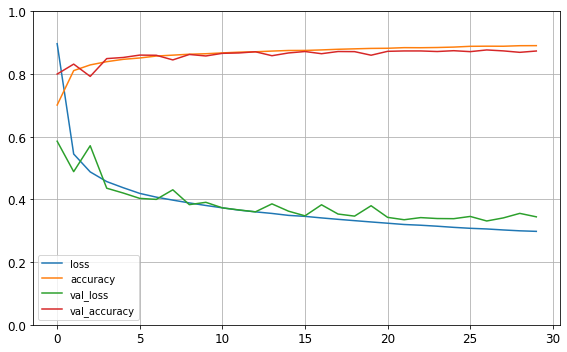

In [53]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [54]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3855 - accuracy: 0.8630


[0.3855377733707428, 0.8629999756813049]

In [62]:
X_new = X_test[:5]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.07, 0.01, 0.87],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.08, 0.  , 0.07, 0.  , 0.1 , 0.  , 0.75, 0.  , 0.  , 0.  ]],
      dtype=float32)

In [63]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1, 1, 6])

In [64]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt'],
      dtype='<U11')

In [60]:
y_new = y_test[:5]
y_new

array([9, 2, 1, 1, 6], dtype=uint8)

Saving figure fashion_mnist_images_plot


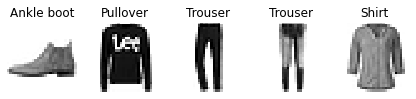

In [65]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 5, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()